In [1]:
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv(r"C:\Users\eweis\Desktop\NBA_freethrows.csv")


C:\Users\eweis\AppData\Local\Temp\ipykernel_20036\3369352395.py:1: DtypeWarning: Columns (1,2,4,5,6,7,14,16,20,21,22,24,25,26,28,29,30,32,34,35,37,39,47,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\eweis\Desktop\NBA_freethrows.csv")


In [5]:
df.columns


Index(['actionNumber', 'clock', 'timeActual', 'period', 'periodType',
       'actionType', 'subType', 'qualifiers', 'personId', 'x', 'y',
       'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'isTargetScoreLastPeriod', 'xLegacy', 'yLegacy', 'isFieldGoal', 'side',
       'description', 'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName',
       'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'area', 'areaDetail',
       'shotDistance', 'shotResult', 'ft_made', 'blockPlayerName',
       'blockPersonId', 'shotActionNumber', 'reboundTotal',
       'reboundDefensiveTotal', 'reboundOffensiveTotal', 'officialId',
       'turnoverTotal', 'stealPlayerName', 'stealPersonId', 'pointsTotal',
       'assistPlayerNameInitial', 'assistPersonId', 'assistTotal',
       'foulPersonalTotal', 'foulTechnicalTotal', 'foulDrawnPlayerNa

In [7]:
df['score_diff'] = abs(df['scoreHome'] - df['scoreAway'])


In [9]:
df['pressure'] = ((df['period'] == 4) & (df['score_diff'] <= 5)).astype(int)


In [11]:
df[['ft_made', 'pressure', 'score_diff', 'period']].head(20)


,ft_made,pressure,score_diff,period
0,0,0,0.0,1.0
1,0,0,0.0,1.0
2,0,0,0.0,1.0
3,0,0,0.0,1.0
4,0,0,0.0,1.0
5,0,0,0.0,1.0
6,0,0,0.0,1.0
7,0,0,0.0,1.0
8,0,0,0.0,1.0
9,0,0,0.0,1.0


In [13]:
df.groupby('pressure')['ft_made'].mean()


pressure
0    0.134388
1    0.195529
Name: ft_made, dtype: float64

In [15]:
df['actionType'].value_counts().head(15)


actionType
substitution    140816
rebound         128702
2pt             127074
3pt              92455
freethrow        53312
foul             47029
turnover         35171
steal            20182
timeout          13678
block            11994
period            9968
jumpball          2193
violation         2114
game              1230
ejection            90
Name: count, dtype: int64

In [17]:
df_ft = df[
    (df['actionType'] == 'freethrow') &
    (df['shotResult'].isin(['Made', 'Missed']))
].copy()


In [19]:
df_ft['ft_made'].mean()


0.7798244297719088

In [21]:
df_ft['score_diff'] = (df_ft['scoreHome'] - df_ft['scoreAway']).abs()


In [23]:
df_ft['close_game'] = (df_ft['score_diff'] <= 5).astype(int)


In [25]:
df_ft['late_game'] = (df_ft['period'] == 4).astype(int)


In [27]:
df_ft['pressure'] = ((df_ft['close_game'] == 1) & (df_ft['late_game'] == 1)).astype(int)


In [29]:
df_ft.groupby('pressure')['ft_made'].mean()


pressure
0    0.781127
1    0.766082
Name: ft_made, dtype: float64

In [31]:
df_ft['clock'].head(10)


19    PT10M24.00S
21    PT10M24.00S
31    PT09M11.00S
32    PT09M11.00S
52    PT07M36.00S
54    PT07M36.00S
76    PT05M57.00S
85    PT05M57.00S
92    PT04M51.00S
95    PT04M51.00S
Name: clock, dtype: object

In [33]:
df_ft['clock_seconds'] = (
    df_ft['clock']
    .str.replace('PT', '', regex=False)
    .str.replace('S', '', regex=False)
)

# split minutes and seconds
df_ft[['min_rem', 'sec_rem']] = df_ft['clock_seconds'].str.split('M', expand=True)

df_ft['min_rem'] = pd.to_numeric(df_ft['min_rem'], errors='coerce')
df_ft['sec_rem'] = pd.to_numeric(df_ft['sec_rem'], errors='coerce')

df_ft['time_remaining_sec'] = df_ft['min_rem']*60 + df_ft['sec_rem']


In [35]:
df_ft['clutch'] = (
    (df_ft['period'] == 4) &
    (df_ft['time_remaining_sec'] <= 120) &
    (df_ft['score_diff'] <= 5)
).astype(int)


In [37]:
df_ft.groupby('clutch')['ft_made'].mean()


clutch
0    0.780187
1    0.768871
Name: ft_made, dtype: float64

In [39]:
df_ft['clutch'].value_counts()

clutch
0    51603
1     1709
Name: count, dtype: int64

In [41]:
import statsmodels.api as sm

X = df_ft[['clutch']]
X = sm.add_constant(X)

y = df_ft['ft_made']

model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.527119
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                ft_made   No. Observations:                53312
Model:                          Logit   Df Residuals:                    53310
Method:                           MLE   Df Model:                            1
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:               2.171e-05
Time:                        19:36:49   Log-Likelihood:                -28102.
converged:                       True   LL-Null:                       -28102.
Covariance Type:            nonrobust   LLR p-value:                    0.2694
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2668      0.011    119.167      0.000       1.246       1.288
clutch        -0.0648      0.

In [45]:
# baseline skill = non-clutch FT% for each player
baseline = (
    df_ft[df_ft['clutch'] == 0]
    .groupby('playerName')['ft_made']
    .mean()
    .rename('H_baseline')
)

df_hs = df_ft.join(baseline, on='playerName')

# drop players with no baseline estimate
df_hs = df_hs.dropna(subset=['H_baseline'])


In [47]:
df_hs['D'] = df_hs['clutch']              # drive / pressure
df_hs['H'] = df_hs['H_baseline']          # habit strength
df_hs['DH'] = df_hs['D'] * df_hs['H']     # interaction


In [49]:
df_hs['H_bin'] = pd.qcut(df_hs['H'], q=4, labels=['Low H','Mid-Low H','Mid-High H','High H'])

summary = (
    df_hs.groupby(['H_bin','clutch'])['ft_made']
    .mean()
    .unstack()
)

summary['drop_under_pressure'] = summary[0] - summary[1]
summary


C:\Users\eweis\AppData\Local\Temp\ipykernel_20036\1166296450.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hs.groupby(['H_bin','clutch'])['ft_made']


clutch,0,1,drop_under_pressure
H_bin,,,
Low H,0.662297,0.664452,-0.002155
Mid-Low H,0.768047,0.700000,0.068047
Mid-High H,0.816049,0.803181,0.012868
High H,0.877577,0.833043,0.044533


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = df_hs[['H','D','DH']]
y = df_hs['ft_made']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

pred = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, pred), dict(zip(X.columns, clf.coef_[0]))


(0.6302804551156582,
 {'H': 5.523361932370365,
  'D': -0.15955897091124915,
  'DH': -0.01705826637515682})

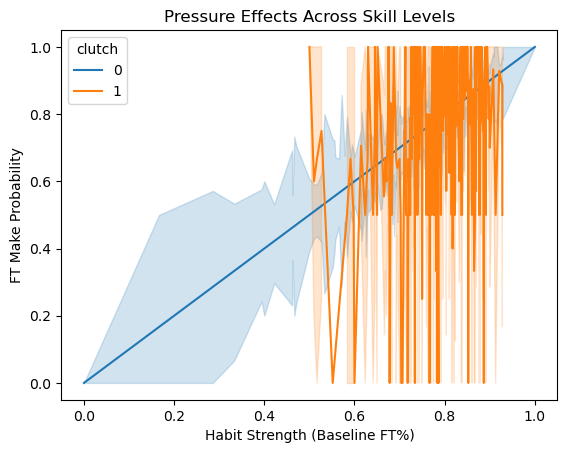

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=df_hs,
    x='H',
    y='ft_made',
    hue='clutch',
    estimator='mean'
)
plt.xlabel("Habit Strength (Baseline FT%)")
plt.ylabel("FT Make Probability")
plt.title("Pressure Effects Across Skill Levels")
plt.show()


C:\Users\eweis\AppData\Local\Temp\ipykernel_20036\1849469043.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['H_bin', 'clutch'])['ft_made']


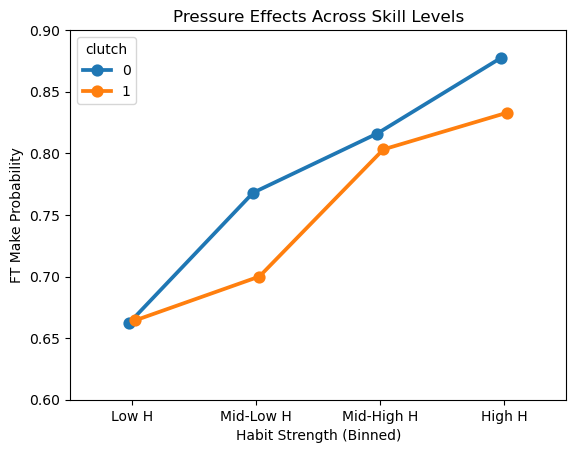

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bin habit strength into quartiles
df_hs['H_bin'] = pd.qcut(df_hs['H'], q=4, labels=['Low H', 'Mid-Low H', 'Mid-High H', 'High H'])

# Compute means
plot_df = (
    df_hs
    .groupby(['H_bin', 'clutch'])['ft_made']
    .mean()
    .reset_index()
)

# Plot
sns.pointplot(
    data=plot_df,
    x='H_bin',
    y='ft_made',
    hue='clutch',
    dodge=True,
    capsize=0.1
)

plt.ylim(0.6, 0.9)
plt.ylabel("FT Make Probability")
plt.xlabel("Habit Strength (Binned)")
plt.title("Pressure Effects Across Skill Levels")
plt.show()


In [61]:
df_ft.columns


Index(['actionNumber', 'clock', 'timeActual', 'period', 'periodType',
       'actionType', 'subType', 'qualifiers', 'personId', 'x', 'y',
       'possession', 'scoreHome', 'scoreAway', 'edited', 'orderNumber',
       'isTargetScoreLastPeriod', 'xLegacy', 'yLegacy', 'isFieldGoal', 'side',
       'description', 'personIdsFilter', 'teamId', 'teamTricode', 'descriptor',
       'jumpBallRecoveredName', 'jumpBallRecoverdPersonId', 'playerName',
       'playerNameI', 'jumpBallWonPlayerName', 'jumpBallWonPersonId',
       'jumpBallLostPlayerName', 'jumpBallLostPersonId', 'area', 'areaDetail',
       'shotDistance', 'shotResult', 'ft_made', 'blockPlayerName',
       'blockPersonId', 'shotActionNumber', 'reboundTotal',
       'reboundDefensiveTotal', 'reboundOffensiveTotal', 'officialId',
       'turnoverTotal', 'stealPlayerName', 'stealPersonId', 'pointsTotal',
       'assistPlayerNameInitial', 'assistPersonId', 'assistTotal',
       'foulPersonalTotal', 'foulTechnicalTotal', 'foulDrawnPlayerNa

C:\Users\eweis\AppData\Local\Temp\ipykernel_20036\3597941960.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ft.groupby(["H_bin", "clutch"])["ft_made"]


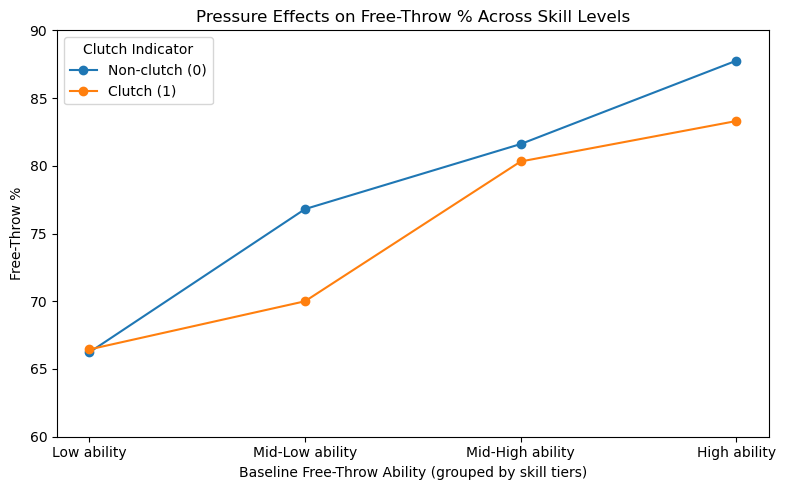

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure ft_made and clutch are numeric 0/1
df_ft = df_ft.copy()
df_ft["ft_made"] = pd.to_numeric(df_ft["ft_made"], errors="coerce")
df_ft["clutch"] = pd.to_numeric(df_ft["clutch"], errors="coerce")

# 2) Create H = each player's baseline FT% in NON-clutch situations
# (Baseline ability estimate)
H_by_player = (
    df_ft[df_ft["clutch"] == 0]
    .groupby("playerName")["ft_made"]
    .mean()
)

df_ft["H"] = df_ft["playerName"].map(H_by_player)

# 3) Drop rows where H couldn't be computed (players who only appear in clutch, rare)
df_ft = df_ft.dropna(subset=["H", "ft_made", "clutch"])

# 4) Bin baseline ability into quartiles
df_ft["H_bin"] = pd.qcut(
    df_ft["H"],
    q=4,
    labels=["Low ability", "Mid-Low ability", "Mid-High ability", "High ability"]
)

# 5) Compute mean FT% by ability bin and clutch context
plot_df = (
    df_ft.groupby(["H_bin", "clutch"])["ft_made"]
    .mean()
    .reset_index()
)

wide = plot_df.pivot(index="H_bin", columns="clutch", values="ft_made")
wide = wide.reindex(["Low ability", "Mid-Low ability", "Mid-High ability", "High ability"])

# 6) Plot (clearer labels)
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(wide.index, wide[0] * 100, marker="o", label="Non-clutch (0)")
ax.plot(wide.index, wide[1] * 100, marker="o", label="Clutch (1)")

ax.set_title("Pressure Effects on Free-Throw % Across Skill Levels")
ax.set_xlabel("Baseline Free-Throw Ability (grouped by skill tiers)")
ax.set_ylabel("Free-Throw %")
ax.set_ylim(60, 90)
ax.legend(title="Clutch Indicator")

plt.tight_layout()
plt.show()


C:\Users\eweis\AppData\Local\Temp\ipykernel_20036\1851481353.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ft.groupby(["H_bin", "clutch"])["ft_made"]


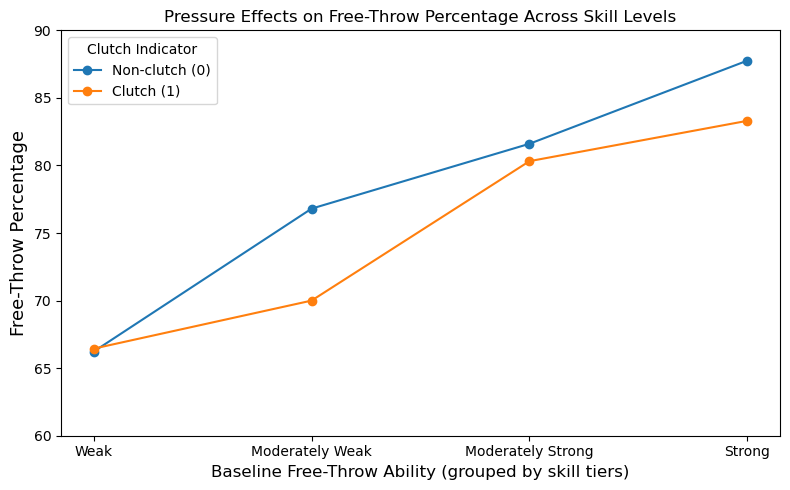

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure ft_made and clutch are numeric 0/1
df_ft = df_ft.copy()
df_ft["ft_made"] = pd.to_numeric(df_ft["ft_made"], errors="coerce")
df_ft["clutch"] = pd.to_numeric(df_ft["clutch"], errors="coerce")

# 2) Create H = each player's baseline FT% in NON-clutch situations
# (Baseline ability estimate)
H_by_player = (
    df_ft[df_ft["clutch"] == 0]
    .groupby("playerName")["ft_made"]
    .mean()
)

df_ft["H"] = df_ft["playerName"].map(H_by_player)

# 3) Drop rows where H couldn't be computed (players who only appear in clutch, rare)
df_ft = df_ft.dropna(subset=["H", "ft_made", "clutch"])

# 4) Bin baseline ability into quartiles
df_ft["H_bin"] = pd.qcut(
    df_ft["H"],
    q=4,
    labels=["Weak", "Moderately Weak", "Moderately Strong", "Strong"]
)

# 5) Compute mean FT% by ability bin and clutch context
plot_df = (
    df_ft.groupby(["H_bin", "clutch"])["ft_made"]
    .mean()
    .reset_index()
)

wide = plot_df.pivot(index="H_bin", columns="clutch", values="ft_made")
wide = wide.reindex(["Weak", "Moderately Weak", "Moderately Strong", "Strong"])

# 6) Plot (clearer labels)
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(wide.index, wide[0] * 100, marker="o", label="Non-clutch (0)")
ax.plot(wide.index, wide[1] * 100, marker="o", label="Clutch (1)")

ax.set_title("Pressure Effects on Free-Throw Percentage Across Skill Levels")
ax.set_xlabel("Baseline Free-Throw Ability (grouped by skill tiers)", fontsize=12)
ax.set_ylabel("Free-Throw Percentage", fontsize=13)
ax.set_ylim(60, 90)
ax.legend(title="Clutch Indicator")

plt.tight_layout()
plt.show()